In [8]:
!python -m spacy download en_core_web_md -qq

/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=36368) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Import

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # see the value of multiple statements at once.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import spacy
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()  # Visualise inside a notebook
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

assets_dir = 'assets'
workers = 6


# Collect Data

In [13]:
repos = pd.read_json(f'{assets_dir}/output.json')
repos.info()
repos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15862 entries, 0 to 15861
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           15862 non-null  object
 1   owner          15862 non-null  object
 2   description    15862 non-null  object
 3   topics         15862 non-null  object
 4   url            15862 non-null  object
 5   readme_base64  15862 non-null  object
dtypes: object(6)
memory usage: 743.7+ KB


,name,owner,description,topics,url,readme_base64
0,hub,mislav,A command-line tool that makes git easier to u...,"[go, homebrew, git, github-api, pull-request]",https://github.com/mislav/hub,aHViIGlzIGEgY29tbWFuZCBsaW5lIHRvb2wgdGhhdCB3cm...
1,lantern,getlantern,Lantern官方版本下载 蓝灯 翻墙 代理 科学上网 外网 加速器 梯子 路由 - Быс...,"[lantern, vpn, censorship, circumvention, gfw,...",https://github.com/getlantern/lantern,IyBMYW50ZXJuClshW2VuXShyZXNvdXJjZXMvRW5nbGlzaC...
2,direnv,direnv,unclutter your .profile,"[direnv, environment, shell-extension, bash, z...",https://github.com/direnv/direnv,ZGlyZW52IC0tIHVuY2x1dHRlciB5b3VyIC5wcm9maWxlCj...
3,go-cache,patrickmn,An in-memory key:value store/cache (similar to...,"[go, cache, library]",https://github.com/patrickmn/go-cache,IyBnby1jYWNoZQoKZ28tY2FjaGUgaXMgYW4gaW4tbWVtb3...
4,dns,miekg,DNS library in Go,"[dnssec, go, dns-library, dns]",https://github.com/miekg/dns,WyFbQnVpbGQgU3RhdHVzXShodHRwczovL3RyYXZpcy1jaS...


# Preprocess data

In [15]:
from base64 import standard_b64decode
repos['readme_base64'] = repos['readme_base64'].apply(lambda x: standard_b64decode(x).decode('utf-8'))
repos['topics'] = repos['topics'].apply(lambda x: ' '.join(x))
repos['merged'] = repos['description'] + ' ' + repos['topics'] + ' ' + repos['readme_base64']
nlp = spacy.load('en_core_web_md')
removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

for merged_readme in nlp.pipe(repos['merged']):
   proj_tok = [token.lemma_.lower() for token in merged_readme if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

repos['tokens'] = tokens



KeyboardInterrupt



# Create a dictionary and a corpus

In [4]:
dictionary = Dictionary(repos['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in repos['tokens']]

# Evaluate the model and visualize the topics with the highest coherence score

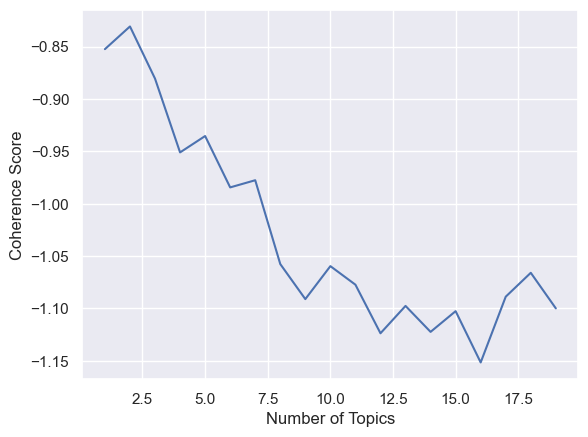

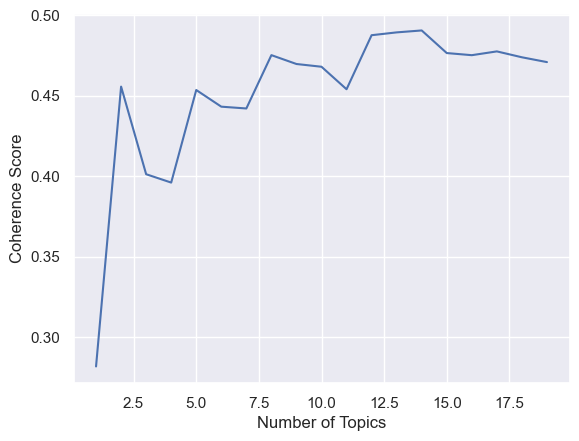

In [5]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = workers, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = workers, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = repos['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()



# Best Model

In [4]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = workers, passes=100)
lda_model.print_topics(-1)

import pickle
pickle.dump(lda_model, open(f'{assets_dir}/lda_model_best.pkl', 'wb'))

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, f'{assets_dir}/index.html')

NameError: name 'corpus' is not defined

# Assign topics to the data

Assign the topics to the data and save the topics and the data in a json file.

In [7]:
import json

data_topics = []
for i in range(repos.shape[0]):
   topics = lda_model[corpus][i]
   topics = sorted(topics, key=lambda x: x[1], reverse=True)
   topics = {
        f"topic_{topic[0]}": str(topic[1])
        for topic in topics
   }
   data_topics.append(
      {
         "name": repos.iloc[i]['name'],
         "owner": repos.iloc[i]['owner'],
         "topics": topics
      }
   )
json.dump(lda_model.print_topics(-1), open(f'{assets_dir}/topics.json', 'w'))
json.dump(data_topics, open(f'{assets_dir}/data_topics.json', 'w'))

In [9]:
import pickle
pickle.dump(lda_model, open(f'{assets_dir}/lda_model_best.pkl', 'wb'))

In [ ]:
#lda_load = pickle.load(open(f'{assets_dir}/lda_model.pkl', 'rb'))
#lda_load.print_topics(-1)